### See what TCA looks like on the Spiking Data

### Setup

In [1]:
# Try to decode which feature was selected per-trial based on firing rates of neurons
# experiment with ranges of firing rates around fixation (selection) time

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.stats
from lfp_tools import (
    general as lfp_general,
    startup as lfp_startup,
    development as lfp_development,
    analysis as lfp_analysis
)
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import s3fs
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils
import utils.io_utils as io_utils
from trial_splitters.random_splitter import RandomSplitter
from trial_splitters.block_splitter import BlockSplitter
from trial_splitters.kfold_splitter import KFoldSplitter
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import pickle

from models.value_models import ValueNormedModel, ValueNormedHiddenModel
from models.model_wrapper import ModelWrapper, ModelWrapperLinearRegression

from models.trainer import Trainer

import torch

import plotly.express as px
import tensortools as tt

import scipy.stats as sci_stats




matplotlib.rcParams['figure.dpi'] = 150


species = 'nhp'
subject = 'SA'
exp = 'WCST'
session = 20180802  # this is the session for which there are spikes at the moment. 

feature_dims = ["Color", "Shape", "Pattern"]

pre_interval = 1300
post_interval = 1500

In [16]:
# grab behavioral data, spike data, trial numbers. 
fs = s3fs.S3FileSystem()
behavior_file = spike_general.get_behavior_path(subject, session)
behavior_data = pd.read_csv(fs.open(behavior_file))
valid_beh = behavior_data[behavior_data.Response.isin(["Correct", "Incorrect"])] 
valid_beh["PrevResponse"] = valid_beh["Response"].shift()  
shuffled_card_idxs = behavioral_utils.get_shuffled_card_idxs(valid_beh)
valid_beh = valid_beh[valid_beh.TrialNumber >= 57]

/tmp/ipykernel_472276/3817408366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_beh["PrevResponse"] = valid_beh["Response"].shift()


### Grab and Rearange Firing Rates

In [17]:
firing_rates = pd.read_pickle(fs.open("l2l.pqz317.scratch/firing_rates_1300_fb_1500_100_bins.pickle"))
firing_rates = firing_rates[firing_rates.TimeBins >= 1.3]
firing_rates = firing_rates[firing_rates.TrialNumber.isin(valid_beh.TrialNumber)]


In [18]:
# want to transform into neurons x time bins x trials
num_time_bins = len(firing_rates["TimeBins"].unique())
num_units = len(firing_rates["UnitID"].unique())
num_trials = len(firing_rates["TrialNumber"].unique())
sorted = firing_rates.sort_values(by=["UnitID", "TimeBins", "TrialNumber"])
firing_rate_data = sorted["FiringRate"].to_numpy().reshape((num_units, num_time_bins, num_trials))


In [19]:
firing_rate_data.shape

(59, 15, 1692)

### Grab Unit Locations

In [20]:
temp_units = spike_utils.get_temporal_drive_unit_ids(fs, subject, session)
ant_units = spike_utils.get_anterior_drive_unit_ids(fs, subject, session)

In [21]:
firing_rate_data = firing_rate_data[np.concatenate((temp_units, ant_units)), : :]

In [22]:
firing_rate_data.shape

(59, 15, 1692)

### Fit TCA

In [ ]:
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(firing_rate_data, ranks=range(1, 11), replicates=4)
# save TCA object
pickle.dump(ensemble, fs.open(f"l2l.pqz317.scratch/tca_fb.pickle", "wb"))

### Plot objective, similarity by rank

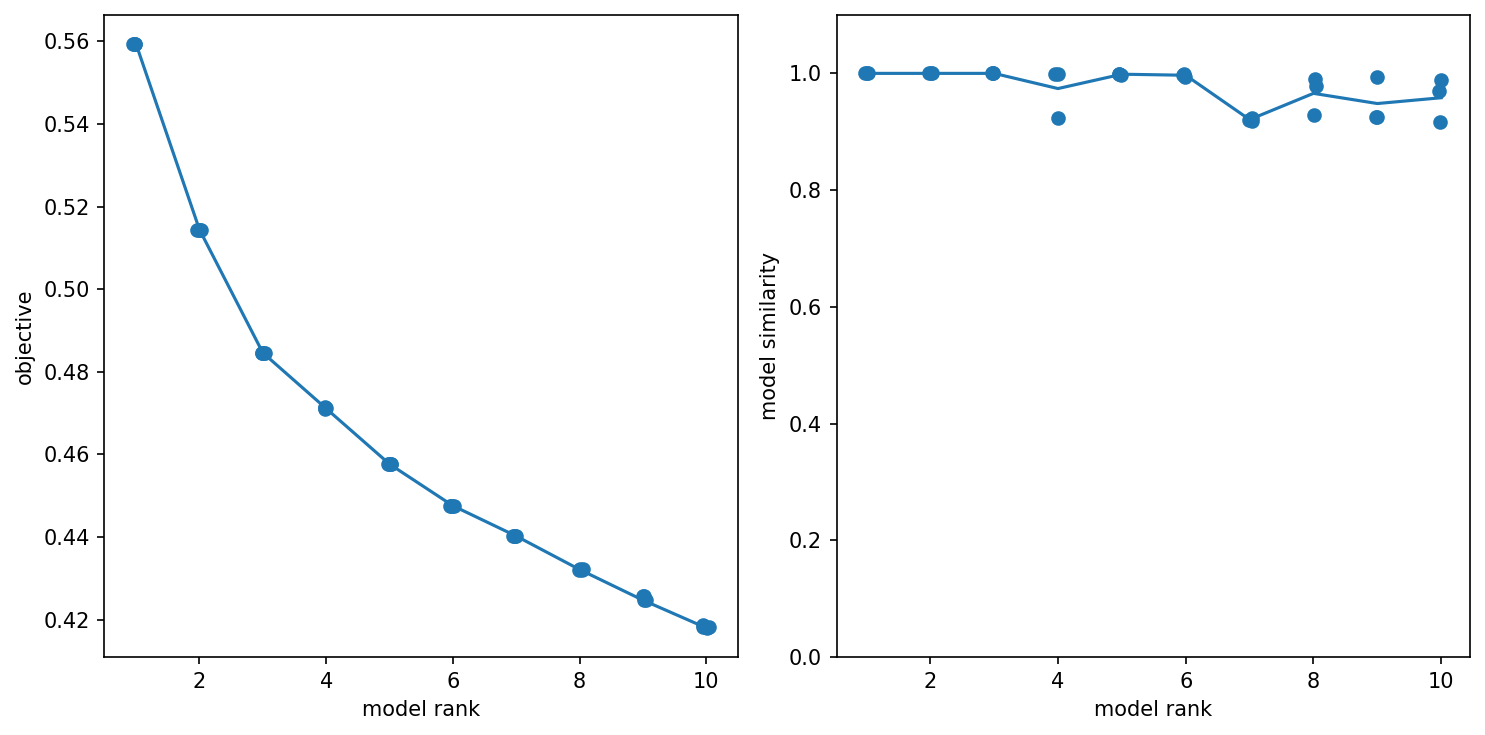

In [77]:
ensemble = pickle.load(fs.open(f"l2l.pqz317.scratch/tca_fb.pickle", "rb"))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
# axes[0].set_ylim((0, 1))
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

Text(0.5, 122.0833333333333, 'Trial Number')

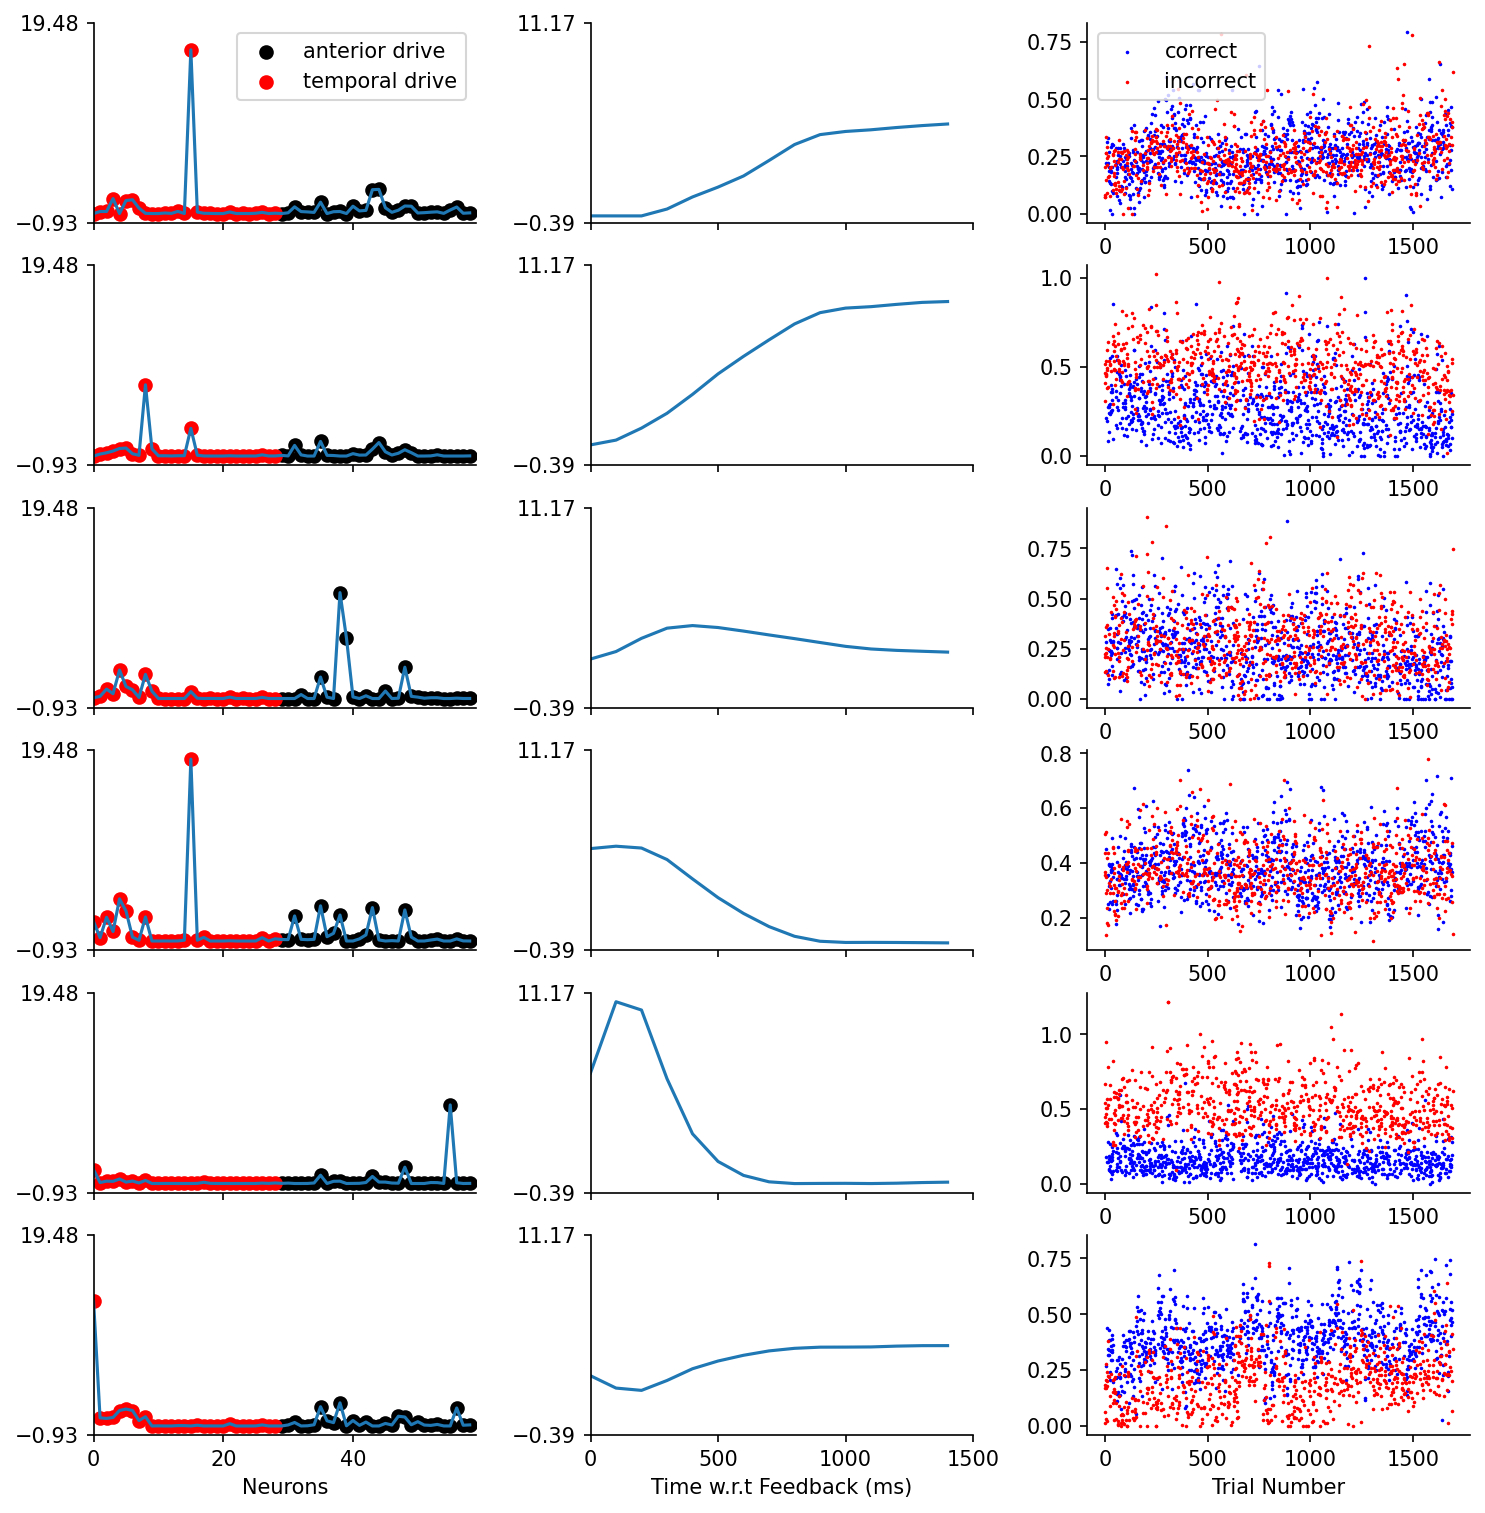

In [78]:
replicate = 0
num_components = 6

neural_factors = ensemble.factors(num_components)[replicate].factors[0]
trial_factors = ensemble.factors(num_components)[replicate].factors[2]

idx_cor = np.argwhere(valid_beh.Response.values=="Correct")[:,0]
idx_inc = np.argwhere(valid_beh.Response.values=="Incorrect")[:,0]

t_idxs = np.arange(0, len(temp_units))
a_idxs = np.arange(len(temp_units), 59)

fig, ax = plt.subplots(num_components, 3, figsize=(10, 10))
fig, ax, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate], fig=fig)  # plot the low-d factors
for i in range(num_components):
    # ax[i][1].axvline(50, color='k')
    plt.setp(ax[i, 1].get_xticklabels(), visible=True)
    ax[i][1].set_xticks([0, 5, 10, 15])
    ax[i][1].set_xticklabels(['0', '500', '1000', '1500'])
    ax[i][0].scatter(a_idxs, neural_factors[:, i][a_idxs], color='black', label='anterior drive')
    ax[i][0].scatter(t_idxs, neural_factors[:, i][t_idxs], color='red', label='temporal drive')
    ax[i][2].clear()
    ax[i][2].scatter(idx_cor, trial_factors[:, i][idx_cor], color='b', label="correct", s=0.5)
    ax[i][2].scatter(idx_inc, trial_factors[:, i][idx_inc], color='r', label="incorrect", s=0.5)
ax[0][2].legend()
ax[0][0].legend()
ax[num_components - 1, 0].set_xlabel("Neurons")
ax[num_components - 1, 1].set_xlabel("Time w.r.t Feedback (ms)")
ax[num_components - 1, 2].set_xlabel("Trial Number")


### TCA on just Incorrect Trials, group trials by whether they were Previously Correct or Incorrect

In [24]:
beh_inc = valid_beh[valid_beh.Response == "Incorrect"]
idx_inc = np.argwhere(valid_beh.Response.values=="Incorrect")[:,0]
inc_fr_data = firing_rate_data[:, :, idx_inc]


In [ ]:
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(inc_fr_data, ranks=range(1, 11), replicates=4)


In [18]:
pickle.dump(ensemble, fs.open(f"l2l.pqz317.scratch/tca_incorrect_fb.pickle", "wb"))

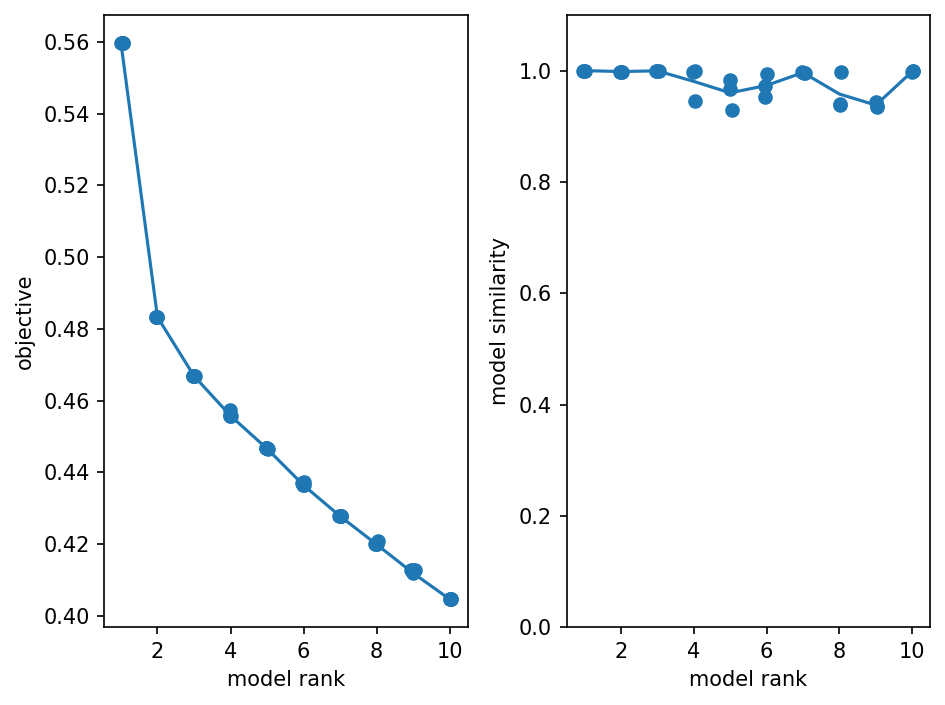

In [26]:
ensemble = pickle.load(fs.open(f"l2l.pqz317.scratch/tca_incorrect_fb.pickle", "rb"))

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
# axes[0].set_ylim((0, 1))
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

Text(0.5, 122.08333333333313, 'Trial Number')

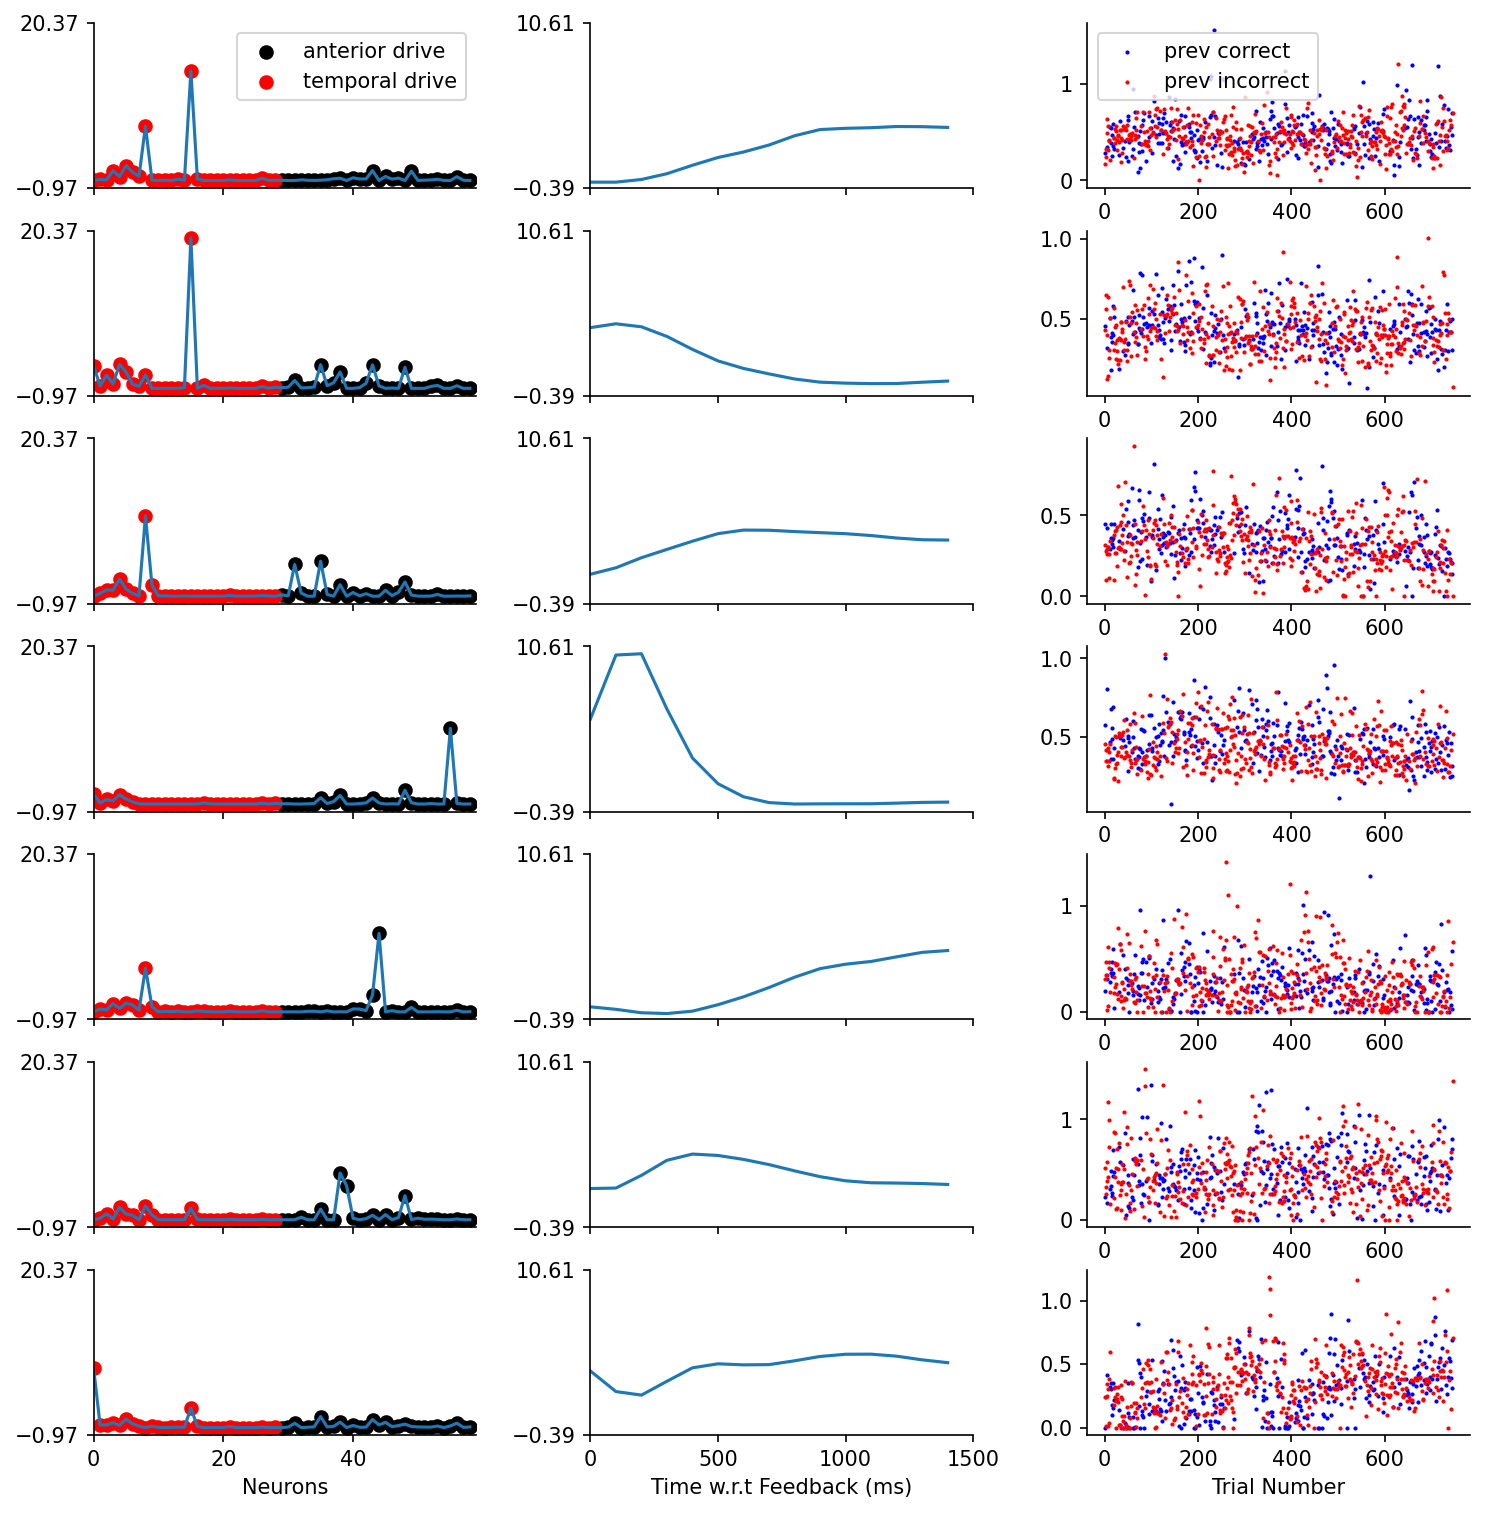

In [27]:
replicate = 0
num_components = 7

neural_factors = ensemble.factors(num_components)[replicate].factors[0]
trial_factors = ensemble.factors(num_components)[replicate].factors[2]

idx_prev_cor = np.argwhere(beh_inc.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(beh_inc.PrevResponse.values=="Incorrect")[:,0]

t_idxs = np.arange(0, len(temp_units))
a_idxs = np.arange(len(temp_units), 59)

fig, ax = plt.subplots(num_components, 3, figsize=(10, 10))
fig, ax, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate], fig=fig)  # plot the low-d factors
for i in range(num_components):
    # ax[i][1].axvline(50, color='k')
    plt.setp(ax[i, 1].get_xticklabels(), visible=True)
    ax[i][1].set_xticks([0, 5, 10, 15])
    ax[i][1].set_xticklabels(['0', '500', '1000', '1500'])
    ax[i][0].scatter(a_idxs, neural_factors[:, i][a_idxs], color='black', label='anterior drive')
    ax[i][0].scatter(t_idxs, neural_factors[:, i][t_idxs], color='red', label='temporal drive')
    ax[i][2].clear()
    ax[i][2].scatter(idx_prev_cor, trial_factors[:, i][idx_prev_cor], color='b', label="prev correct", s=1)
    ax[i][2].scatter(idx_prev_inc, trial_factors[:, i][idx_prev_inc], color='r', label="prev incorrect", s=1)
ax[0][2].legend()
ax[0][0].legend()
ax[num_components-1, 0].set_xlabel("Neurons")
ax[num_components-1, 1].set_xlabel("Time w.r.t Feedback (ms)")
ax[num_components-1, 2].set_xlabel("Trial Number")


### Plot some factors that are interesting

/src/wcst_decode/utils/visualization_utils.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=accuracies, capsize=.1, ci="sd", ax=ax)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3544: UserWarning: 13.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Component 3 of TCA on negative feedback')

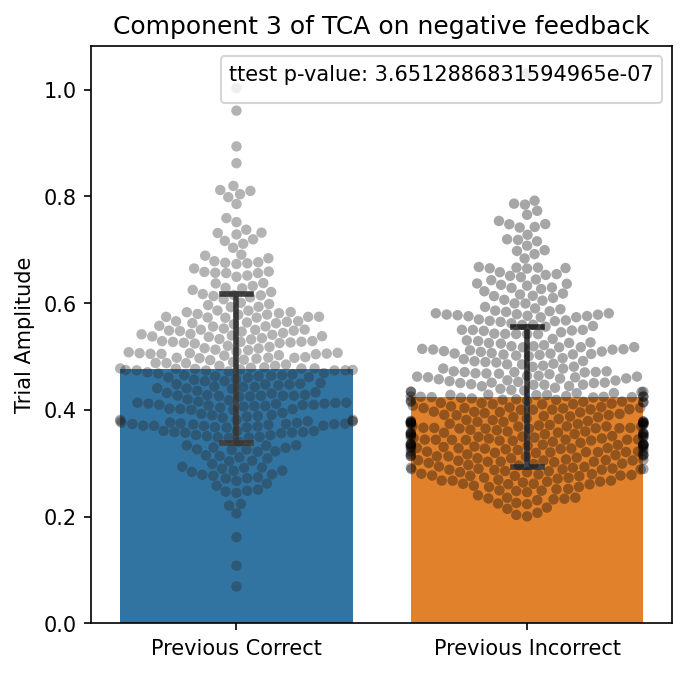

In [28]:
replicate = 0
num_components = 7
comp_id = 3

trial_factors = ensemble.factors(num_components)[replicate].factors[2]
idx_prev_cor = np.argwhere(beh_inc.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(beh_inc.PrevResponse.values=="Incorrect")[:,0]

prev_cor_amps = trial_factors[:, comp_id][idx_prev_cor]
prev_inc_amps = trial_factors[:, comp_id][idx_prev_inc]

stat, pvalue = sci_stats.ttest_ind(prev_cor_amps, prev_inc_amps, equal_var=False)

fig, ax = plt.subplots(figsize=(5, 5))
visualization_utils.visualize_accuracy_bars([prev_cor_amps, prev_inc_amps], ["Previous Correct", "Previous Incorrect"], ax)
ax.set_ylabel(f"Trial Amplitude")
ax.legend(title=f"ttest p-value: {pvalue}")
ax.set_title(f"Component {comp_id} of TCA on negative feedback")

### Do the same thing, now on correct trials

In [29]:
beh_cor = valid_beh[valid_beh.Response == "Correct"]
idx_cor = np.argwhere(valid_beh.Response.values=="Correct")[:,0]
cor_fr_data = firing_rate_data[:, :, idx_cor]


In [30]:
ensemble = tt.Ensemble(fit_method="ncp_hals")
ensemble.fit(cor_fr_data, ranks=range(1, 11), replicates=4)

Fitting rank-1 models:   0%|          | 0/4 [00:00<?, ?it/s]/src/tensortools/tensortools/optimize/ncp_hals.py:185: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Cp = factors[:, idx] @ grams[idx][:, p]
/usr/local/lib/python3.8/dist-packages/numba/core/typing/npydecl.py:913: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
                                                                    

Rank-1 models:  min obj, 0.54;  max obj, 0.54;  time to fit, 0.9s


Rank-2 models:  min obj, 0.50;  max obj, 0.50;  time to fit, 0.7s


Rank-3 models:  min obj, 0.48;  max obj, 0.48;  time to fit, 0.5s


Rank-4 models:  min obj, 0.47;  max obj, 0.47;  time to fit, 0.9s


KeyboardInterrupt: 

In [48]:
pickle.dump(ensemble, fs.open(f"l2l.pqz317.scratch/tca_correct_fb.pickle", "wb"))

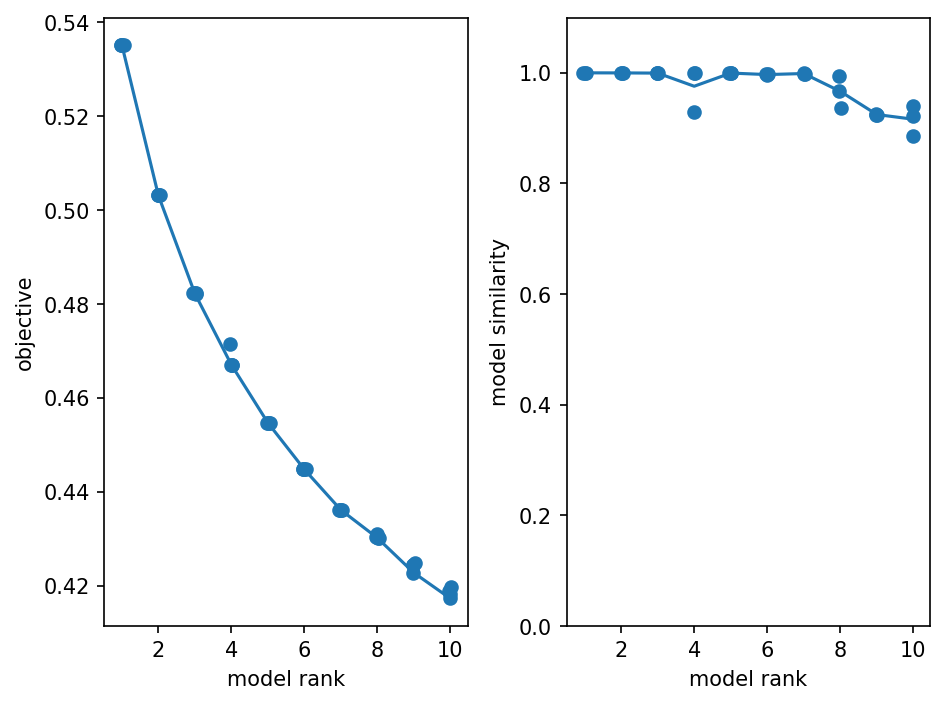

In [31]:
ensemble = pickle.load(fs.open(f"l2l.pqz317.scratch/tca_correct_fb.pickle", "rb"))

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
# axes[0].set_ylim((0, 1))
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

Text(0.5, 122.08333333333313, 'Trial Number')

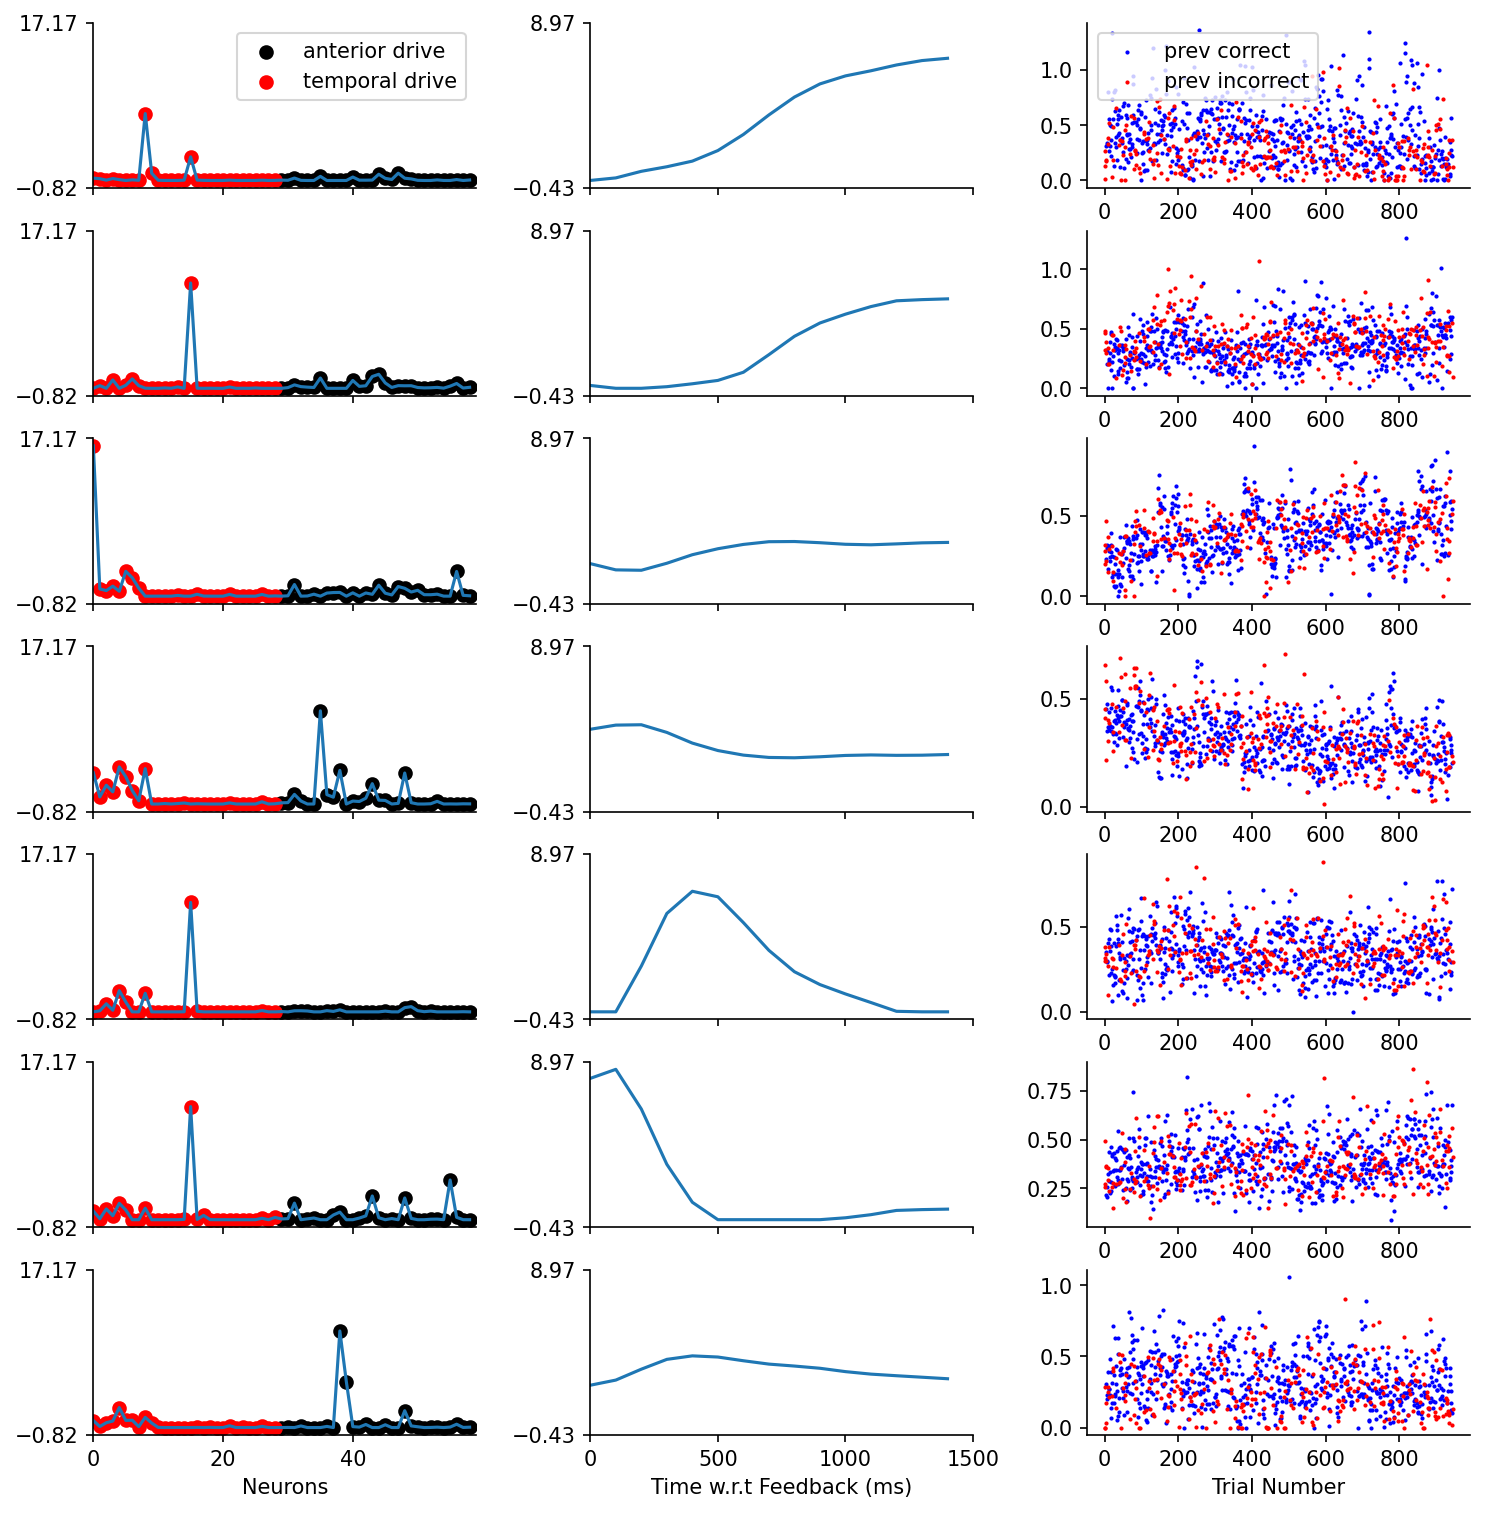

In [32]:
replicate = 0
num_components = 7

neural_factors = ensemble.factors(num_components)[replicate].factors[0]
trial_factors = ensemble.factors(num_components)[replicate].factors[2]

idx_prev_cor = np.argwhere(beh_cor.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(beh_cor.PrevResponse.values=="Incorrect")[:,0]

t_idxs = np.arange(0, len(temp_units))
a_idxs = np.arange(len(temp_units), 59)

fig, ax = plt.subplots(num_components, 3, figsize=(10, 10))
fig, ax, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate], fig=fig)  # plot the low-d factors
for i in range(num_components):
    # ax[i][1].axvline(50, color='k')
    plt.setp(ax[i, 1].get_xticklabels(), visible=True)
    ax[i][1].set_xticks([0, 5, 10, 15])
    ax[i][1].set_xticklabels(['0', '500', '1000', '1500'])
    ax[i][0].scatter(a_idxs, neural_factors[:, i][a_idxs], color='black', label='anterior drive')
    ax[i][0].scatter(t_idxs, neural_factors[:, i][t_idxs], color='red', label='temporal drive')
    ax[i][2].clear()
    ax[i][2].scatter(idx_prev_cor, trial_factors[:, i][idx_prev_cor], color='b', label="prev correct", s=1)
    ax[i][2].scatter(idx_prev_inc, trial_factors[:, i][idx_prev_inc], color='r', label="prev incorrect", s=1)
ax[0][2].legend()
ax[0][0].legend()
ax[num_components-1, 0].set_xlabel("Neurons")
ax[num_components-1, 1].set_xlabel("Time w.r.t Feedback (ms)")
ax[num_components-1, 2].set_xlabel("Trial Number")


/src/wcst_decode/utils/visualization_utils.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=accuracies, capsize=.1, ci="sd", ax=ax)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:0'` for same effect.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3544: UserWarning: 10.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Component 0 of TCA on positive feedback')

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3544: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


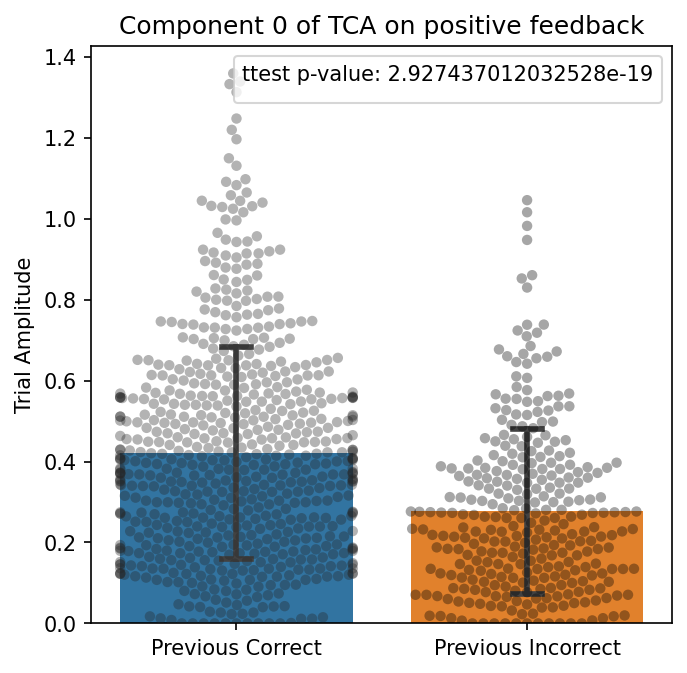

In [33]:
replicate = 0
num_components = 7
comp_id = 0

trial_factors = ensemble.factors(num_components)[replicate].factors[2]
idx_prev_cor = np.argwhere(beh_cor.PrevResponse.values=="Correct")[:,0]
idx_prev_inc = np.argwhere(beh_cor.PrevResponse.values=="Incorrect")[:,0]

prev_cor_amps = trial_factors[:, comp_id][idx_prev_cor]
prev_inc_amps = trial_factors[:, comp_id][idx_prev_inc]

stat, pvalue = sci_stats.ttest_ind(prev_cor_amps, prev_inc_amps, equal_var=False)

fig, ax = plt.subplots(figsize=(5, 5))
visualization_utils.visualize_accuracy_bars([prev_cor_amps, prev_inc_amps], ["Previous Correct", "Previous Incorrect"], ax)
ax.set_ylabel(f"Trial Amplitude")
ax.legend(title=f"ttest p-value: {pvalue}")
ax.set_title(f"Component {comp_id} of TCA on positive feedback")

### Vishwa's states?

In [102]:
vishwa_states = lfp_development.get_vishwa_states(fs, subject, str(session), behavior_data)
merged = valid_beh.merge(vishwa_states[["trialIndex", "category"]], left_on="TrialNumber", right_on="trialIndex")

merged_cor = merged[merged.Response == "Correct"]

Text(0.5, 122.08333333333313, 'Trial Number')

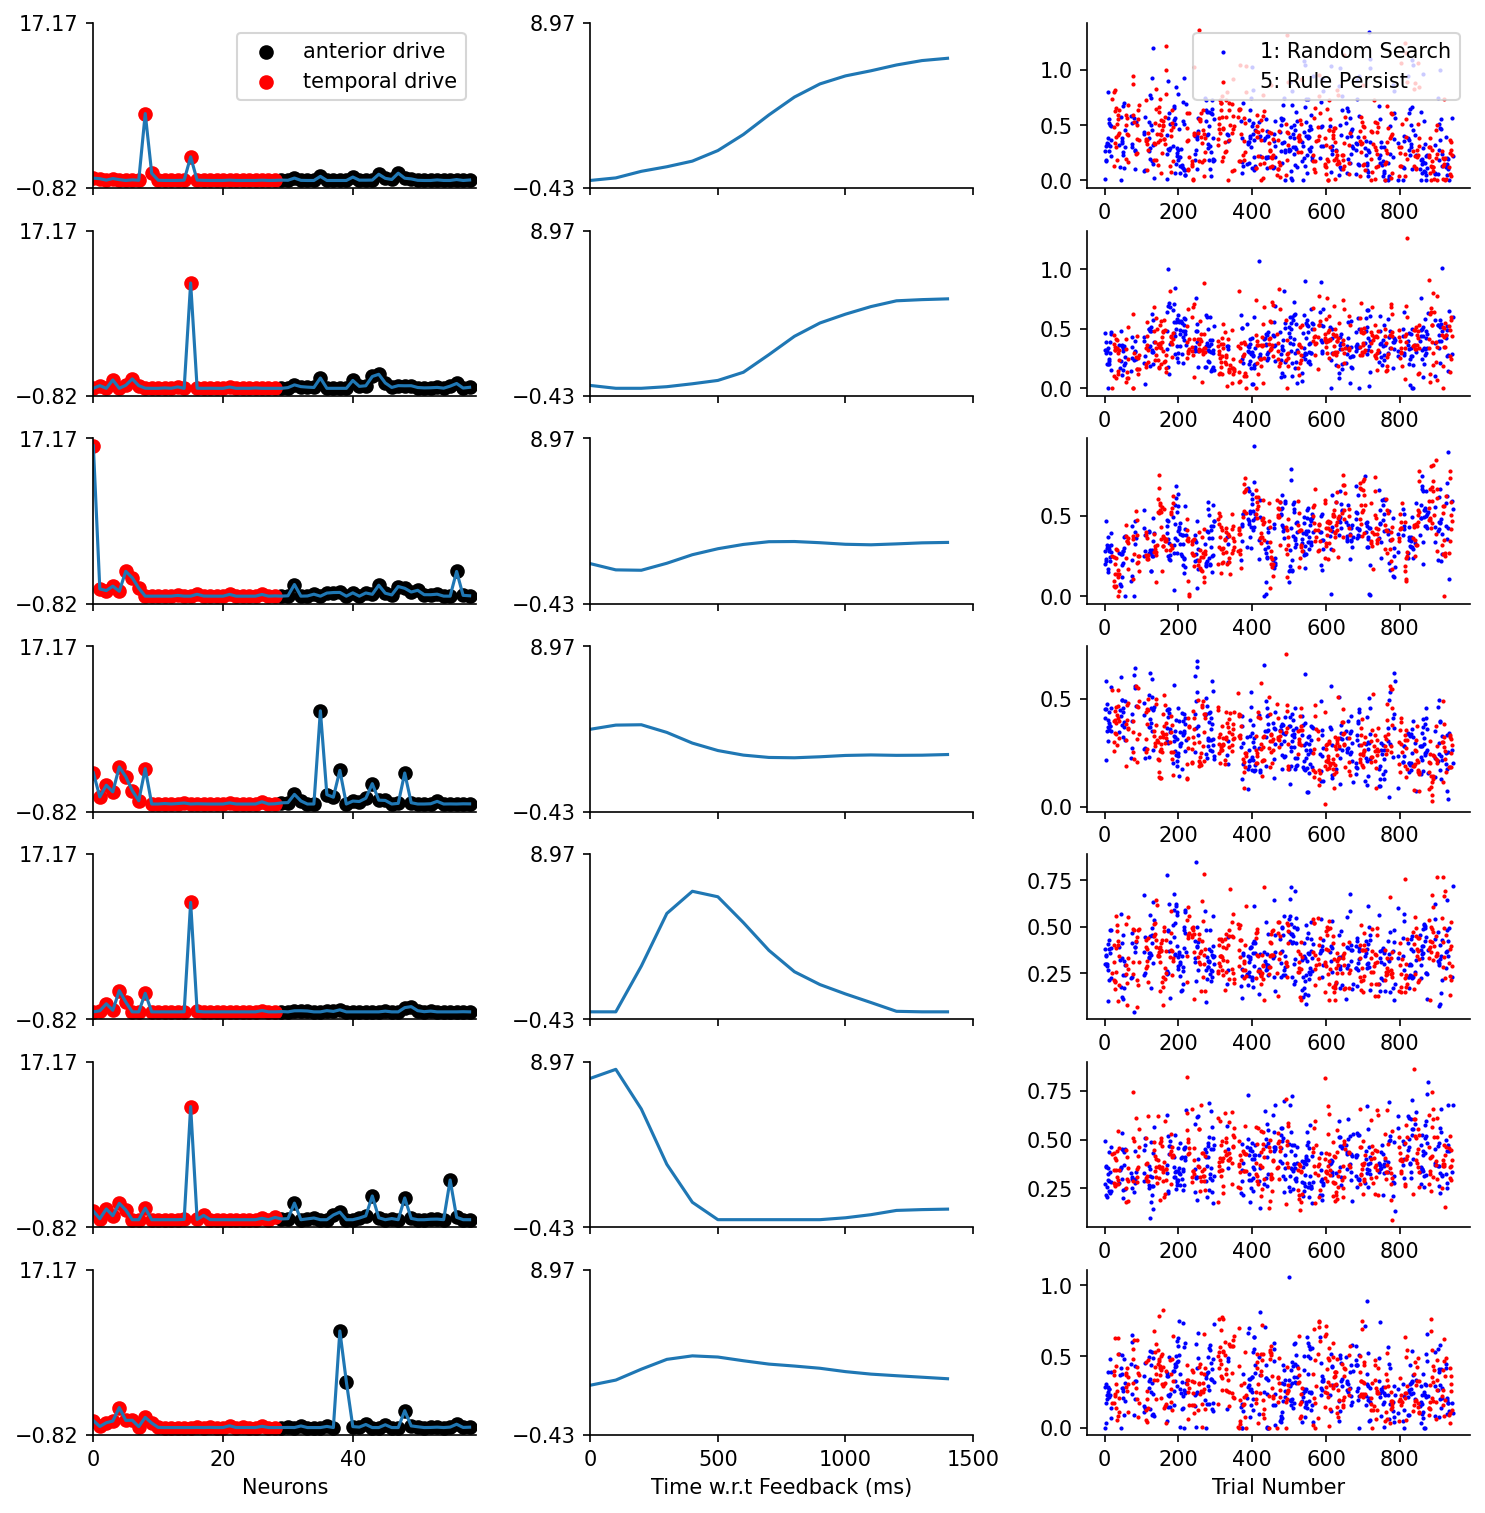

In [106]:
ensemble = pickle.load(fs.open(f"l2l.pqz317.scratch/tca_correct_fb.pickle", "rb"))
replicate = 0
num_components = 7

neural_factors = ensemble.factors(num_components)[replicate].factors[0]
trial_factors = ensemble.factors(num_components)[replicate].factors[2]

idx_explore = np.argwhere(np.isin(merged_cor.category.values, [1, 2, 3]))[:,0]
idx_rule_persist = np.argwhere(merged_cor.category.values==5)[:,0]

t_idxs = np.arange(0, len(temp_units))
a_idxs = np.arange(len(temp_units), 59)

fig, ax = plt.subplots(num_components, 3, figsize=(10, 10))
fig, ax, plot_obj = tt.plot_factors(ensemble.factors(num_components)[replicate], fig=fig)  # plot the low-d factors
for i in range(num_components):
    # ax[i][1].axvline(50, color='k')
    plt.setp(ax[i, 1].get_xticklabels(), visible=True)
    ax[i][1].set_xticks([0, 5, 10, 15])
    ax[i][1].set_xticklabels(['0', '500', '1000', '1500'])
    ax[i][0].scatter(a_idxs, neural_factors[:, i][a_idxs], color='black', label='anterior drive')
    ax[i][0].scatter(t_idxs, neural_factors[:, i][t_idxs], color='red', label='temporal drive')
    ax[i][2].clear()
    ax[i][2].scatter(idx_explore, trial_factors[:, i][idx_explore], color='b', label="1: Random Search", s=1)
    ax[i][2].scatter(idx_rule_persist, trial_factors[:, i][idx_rule_persist], color='r', label="5: Rule Persist", s=1)
ax[0][2].legend()
ax[0][0].legend()
ax[num_components-1, 0].set_xlabel("Neurons")
ax[num_components-1, 1].set_xlabel("Time w.r.t Feedback (ms)")
ax[num_components-1, 2].set_xlabel("Trial Number")
